In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = ':https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F222%2F472%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240622%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240622T090014Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6ce90e966a088782d6b551b4160a992161bcd61471b722ea1eb01de446444ee196d741bdb57571f86a2905670105c067f1388549a3df8c72823f99752fbd2a3562019c8f228c5c9979ac9e73300b7b08743463175a11fb6646453349420772af864ae7a3b55bace8584fcf58ec37b15a3d0f11258176537813de12436c5b73f5d24a587e9fe51f93da5840b65eb7fe7faf8eaab73f737e916b4a5634c11baa92143addc4bf3a6bbc7a4290f86c904ba0106ff309b197cd958cab99cf95c59fe855483f162c79e68ba753dc4f31cc8915ef88e6ac83a105d0758a1a43f0c9d04d719e3ef696622dcae4fa1e6cd97f9cb93dd5794f43dd37e2460d40688efe7804'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 667679 bytes downloaded
Downloaded and uncompressed: 
Data source import complete.


# **Income Classification Model**

## Fetching Data

### Import Package and Data

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline

In [3]:
income_df = pd.read_csv("../input/adult.csv")
income_df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [4]:
income_df.describe()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


## Data Cleaning

 ### Dealing with Missing Value

In [5]:
income_df.isnull().sum()

age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64

Attributes workclass, occupation, and native-country most NAs. Let's drop these NA.

In [6]:
income_df.age = income_df.age.astype(float)
income_df['hours-per-week'] = income_df['hours-per-week'].astype(float)

In [7]:
my_df = income_df.dropna()

In [8]:
my_df['predclass'] = my_df['income']
del my_df['income']
my_df['education-num'] = my_df['educational-num']
del my_df['educational-num']

In [9]:
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             48842 non-null  float64
 1   workclass       48842 non-null  object 
 2   fnlwgt          48842 non-null  int64  
 3   education       48842 non-null  object 
 4   marital-status  48842 non-null  object 
 5   occupation      48842 non-null  object 
 6   relationship    48842 non-null  object 
 7   race            48842 non-null  object 
 8   gender          48842 non-null  object 
 9   capital-gain    48842 non-null  int64  
 10  capital-loss    48842 non-null  int64  
 11  hours-per-week  48842 non-null  float64
 12  native-country  48842 non-null  object 
 13  predclass       48842 non-null  object 
 14  education-num   48842 non-null  int64  
dtypes: float64(2), int64(4), object(9)
memory usage: 5.6+ MB


In [10]:
my_df.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
marital-status    0
occupation        0
relationship      0
race              0
gender            0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
predclass         0
education-num     0
dtype: int64

## Feature Engineering

In [11]:
print('workclass',my_df.workclass.unique())
print('education',my_df.education.unique())
print('marital-status',my_df['marital-status'].unique())
print('occupation',my_df.occupation.unique())
print('relationship',my_df.relationship.unique())
print('race',my_df.race.unique())
print('gender',my_df.gender.unique())
print('native-country',my_df['native-country'].unique())
print('predclass',my_df.predclass.unique())

workclass ['Private' 'Local-gov' '?' 'Self-emp-not-inc' 'Federal-gov' 'State-gov'
 'Self-emp-inc' 'Without-pay' 'Never-worked']
education ['11th' 'HS-grad' 'Assoc-acdm' 'Some-college' '10th' 'Prof-school'
 '7th-8th' 'Bachelors' 'Masters' 'Doctorate' '5th-6th' 'Assoc-voc' '9th'
 '12th' '1st-4th' 'Preschool']
marital-status ['Never-married' 'Married-civ-spouse' 'Widowed' 'Divorced' 'Separated'
 'Married-spouse-absent' 'Married-AF-spouse']
occupation ['Machine-op-inspct' 'Farming-fishing' 'Protective-serv' '?'
 'Other-service' 'Prof-specialty' 'Craft-repair' 'Adm-clerical'
 'Exec-managerial' 'Tech-support' 'Sales' 'Priv-house-serv'
 'Transport-moving' 'Handlers-cleaners' 'Armed-Forces']
relationship ['Own-child' 'Husband' 'Not-in-family' 'Unmarried' 'Wife' 'Other-relative']
race ['Black' 'White' 'Asian-Pac-Islander' 'Other' 'Amer-Indian-Eskimo']
gender ['Male' 'Female']
native-country ['United-States' '?' 'Peru' 'Guatemala' 'Mexico' 'Dominican-Republic'
 'Ireland' 'Germany' 'Philippines' 

### income

In [ ]:
#my_df.loc[income_df['income'] == ' >50K', 'income'] = 1
#my_df.loc[income_df['income'] == ' <=50K', 'income'] = 0

In [ ]:
#income1 = my_df[my_df['income'] == 1]
#income0 = my_df[my_df['income'] == 0]

<ipython-input-13-4c14494b652e>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-ticks')


<Axes: xlabel='count', ylabel='predclass'>

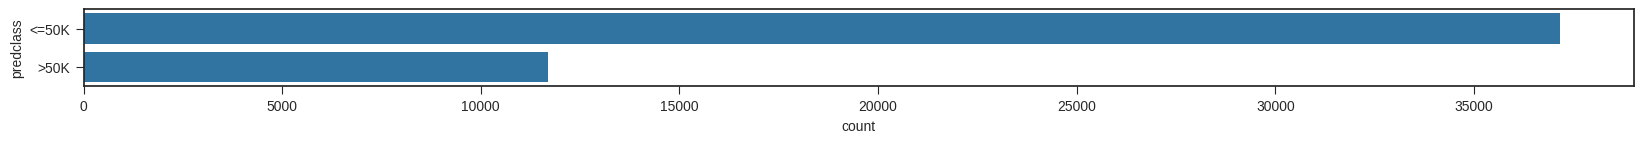

In [13]:
fig = plt.figure(figsize=(20,1))
plt.style.use('seaborn-ticks')
sns.countplot(y='predclass', data=my_df)

Income level less than 50K is more than 3 times of those above 50K, indicating that the the dataset is somewhat skewed. However, since there is no data on the upper limit of adult's income above 50K, it's premature to conclude that the total amount of wealth are skewed towards high income group.

### Education

In [ ]:
#income_df[['education', 'education-num']].groupby(['education'], as_index=False).mean().sort_values(by='education-num', ascending=False)

In [14]:
my_df['education'].replace('Preschool', 'dropout',inplace=True)
my_df['education'].replace('10th', 'dropout',inplace=True)
my_df['education'].replace('11th', 'dropout',inplace=True)
my_df['education'].replace('12th', 'dropout',inplace=True)
my_df['education'].replace('1st-4th', 'dropout',inplace=True)
my_df['education'].replace('5th-6th', 'dropout',inplace=True)
my_df['education'].replace('7th-8th', 'dropout',inplace=True)
my_df['education'].replace('9th', 'dropout',inplace=True)
my_df['education'].replace('HS-Grad', 'HighGrad',inplace=True)
my_df['education'].replace('HS-grad', 'HighGrad',inplace=True)
my_df['education'].replace('Some-college', 'CommunityCollege',inplace=True)
my_df['education'].replace('Assoc-acdm', 'CommunityCollege',inplace=True)
my_df['education'].replace('Assoc-voc', 'CommunityCollege',inplace=True)
my_df['education'].replace('Bachelors', 'Bachelors',inplace=True)
my_df['education'].replace('Masters', 'Masters',inplace=True)
my_df['education'].replace('Prof-school', 'Masters',inplace=True)
my_df['education'].replace('Doctorate', 'Doctorate',inplace=True)

In [15]:
my_df[['education', 'education-num']].groupby(['education'], as_index=False).mean().sort_values(by='education-num', ascending=False)

,education,education-num
2,Doctorate,16.000000
4,Masters,14.238900
0,Bachelors,13.000000
1,CommunityCollege,10.361967
3,HighGrad,9.000000
5,dropout,5.614544


<ipython-input-16-72c53feb210f>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-ticks')


<Axes: xlabel='count', ylabel='education'>

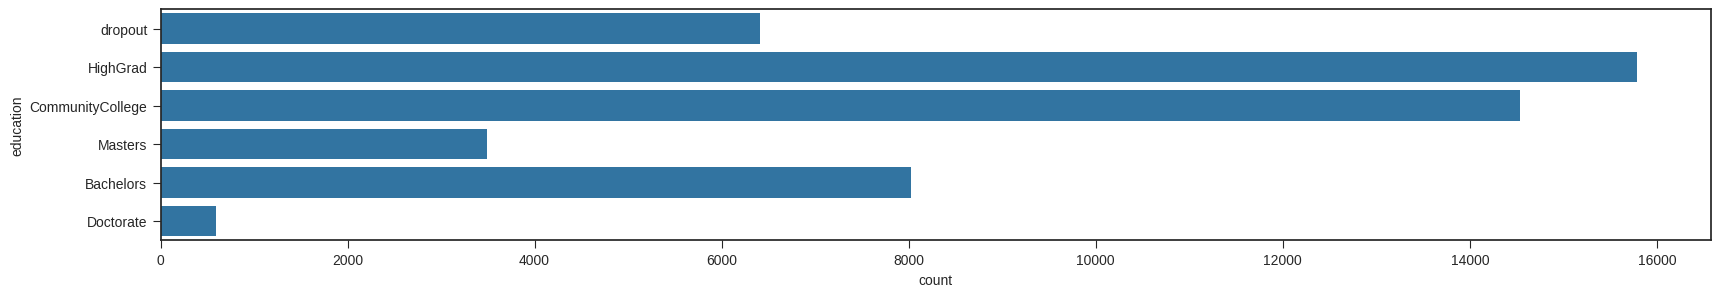

In [16]:
fig = plt.figure(figsize=(20,3))
plt.style.use('seaborn-ticks')
sns.countplot(y="education", data=my_df)

### Marital-status

In [17]:
#df2 = my_df['marital-status'].replace(' Never-married', 'NotMarried')
my_df['marital-status'].replace('Never-married', 'NotMarried',inplace=True)
my_df['marital-status'].replace(['Married-AF-spouse'], 'Married',inplace=True)
my_df['marital-status'].replace(['Married-civ-spouse'], 'Married',inplace=True)
my_df['marital-status'].replace(['Married-spouse-absent'], 'NotMarried',inplace=True)
my_df['marital-status'].replace(['Separated'], 'Separated',inplace=True)
my_df['marital-status'].replace(['Divorced'], 'Separated',inplace=True)
my_df['marital-status'].replace(['Widowed'], 'Widowed',inplace=True)

<ipython-input-18-268f72a2957a>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-ticks')


<Axes: xlabel='count', ylabel='marital-status'>

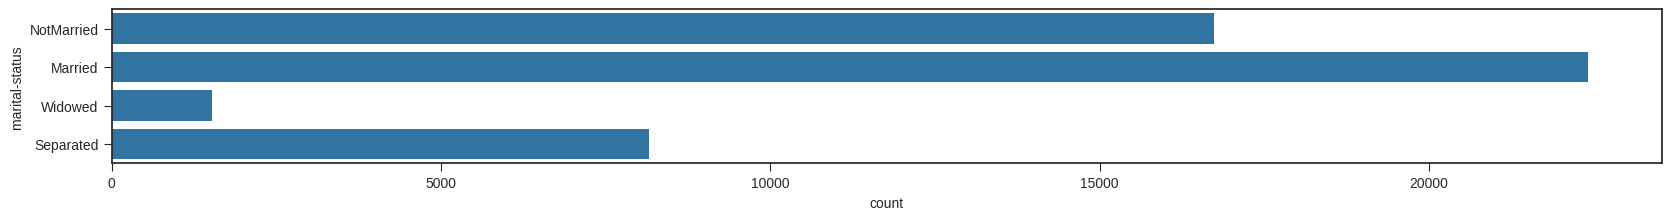

In [18]:
fig = plt.figure(figsize=(20,2))
plt.style.use('seaborn-ticks')
sns.countplot(y="marital-status", data=my_df)

### Occupation

<ipython-input-19-9ce7077d62f4>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-ticks')


<Axes: xlabel='count', ylabel='occupation'>

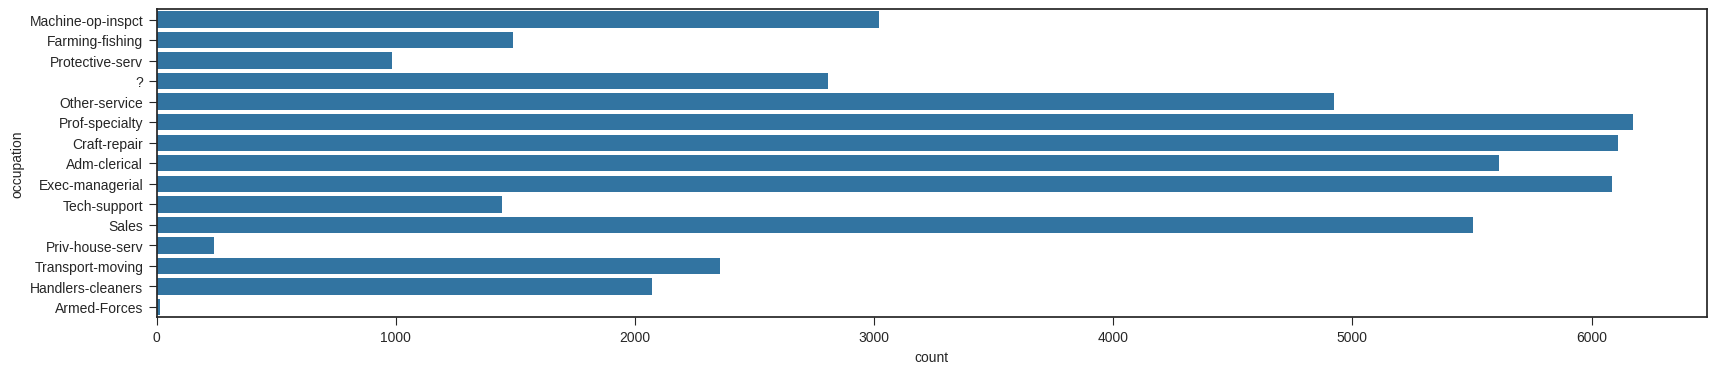

In [19]:
plt.style.use('seaborn-ticks')
plt.figure(figsize=(20,4))
sns.countplot(y="occupation", data=my_df)

### Workclass

<ipython-input-20-0f7e63378bcb>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-ticks')


<Axes: xlabel='count', ylabel='workclass'>

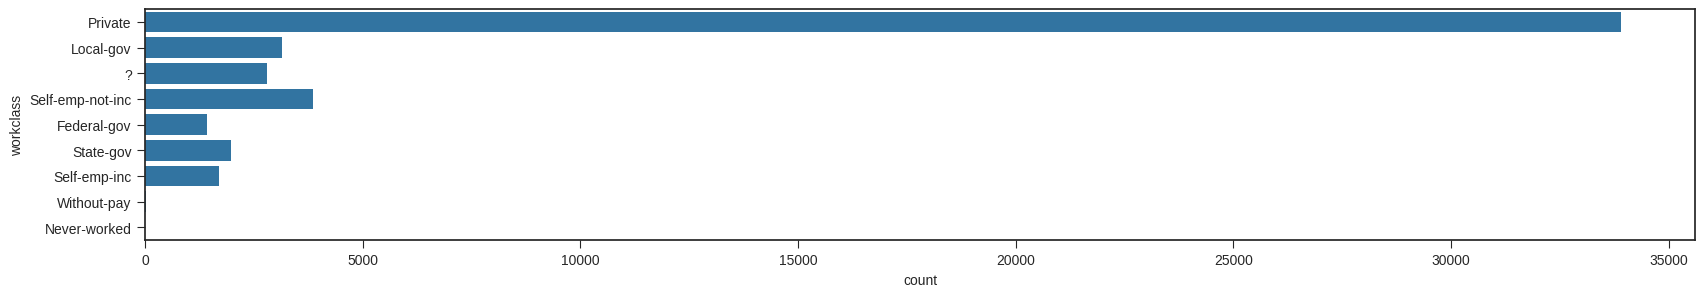

In [20]:
plt.style.use('seaborn-ticks')
plt.figure(figsize=(20,3))
sns.countplot(y="workclass", data=my_df)

### age

In [21]:
# make the age variable discretized
my_df['age_bin'] = pd.cut(my_df['age'], 20)

In [25]:
my_df[['predclass', 'age']].groupby(['predclass'], as_index=False).mean().sort_values(by='age', ascending=False)

,predclass,age
1,>50K,44.275178
0,<=50K,36.872184


### Race

<ipython-input-26-0d8ab2e2f495>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


<Axes: xlabel='race', ylabel='prop'>

<Figure size 2000x500 with 0 Axes>

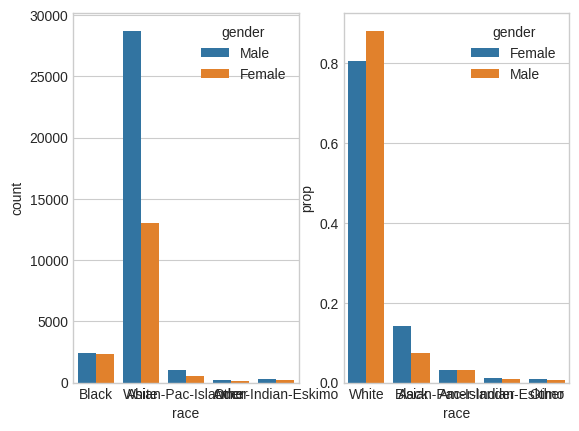

In [26]:
plt.style.use('seaborn-whitegrid')
x, y, hue = "race", "prop", "gender"
#hue_order = ["Male", "Female"]
plt.figure(figsize=(20,5))
f, axes = plt.subplots(1, 2)
sns.countplot(x=x, hue=hue, data=my_df, ax=axes[0])

prop_df = (my_df[x]
           .groupby(my_df[hue])
           .value_counts(normalize=True)
           .rename(y)
           .reset_index())

sns.barplot(x=x, y=y, hue=hue, data=prop_df, ax=axes[1])


### Hours of Work

In [27]:
# Let's use the Pandas Cut function to bin the data in equally sized buckets
my_df['hours-per-week_bin'] = pd.cut(my_df['hours-per-week'], 10)
my_df['hours-per-week'] = my_df['hours-per-week']

<ipython-input-29-2f46c2b5a6c2>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')
<ipython-input-29-2f46c2b5a6c2>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(my_df['hours-per-week']);
<ipython-input-29-2f46c2b5a6c2>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level fun

(20.0, 60.0)

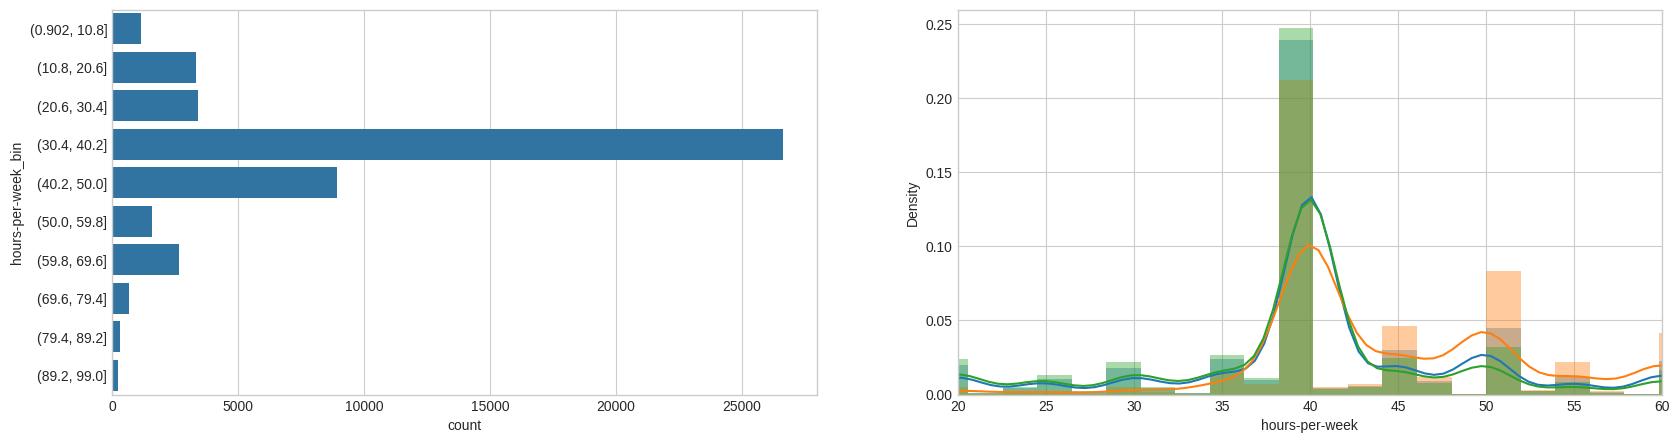

In [29]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
sns.countplot(y="hours-per-week_bin", data=my_df);
plt.subplot(1, 2, 2)
sns.distplot(my_df['hours-per-week']);
sns.distplot(my_df[my_df['predclass'] == '>50K']['hours-per-week'], kde_kws={"label": ">$50K"})
sns.distplot(my_df[my_df['predclass'] == '<=50K']['hours-per-week'], kde_kws={"label": "<$50K"})
plt.ylim(0, None)
plt.xlim(20, 60)


### Create a crossing feature: Age + hour of work

In [ ]:
my_df.head()

In [31]:
# Crossing Numerical Features
my_df['age-hours'] = my_df['age']*my_df['hours-per-week']
my_df['age-hours_bin'] = pd.cut(my_df['age-hours'], 10)

<ipython-input-32-d5e4b0811813>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


KeyError: 'income'

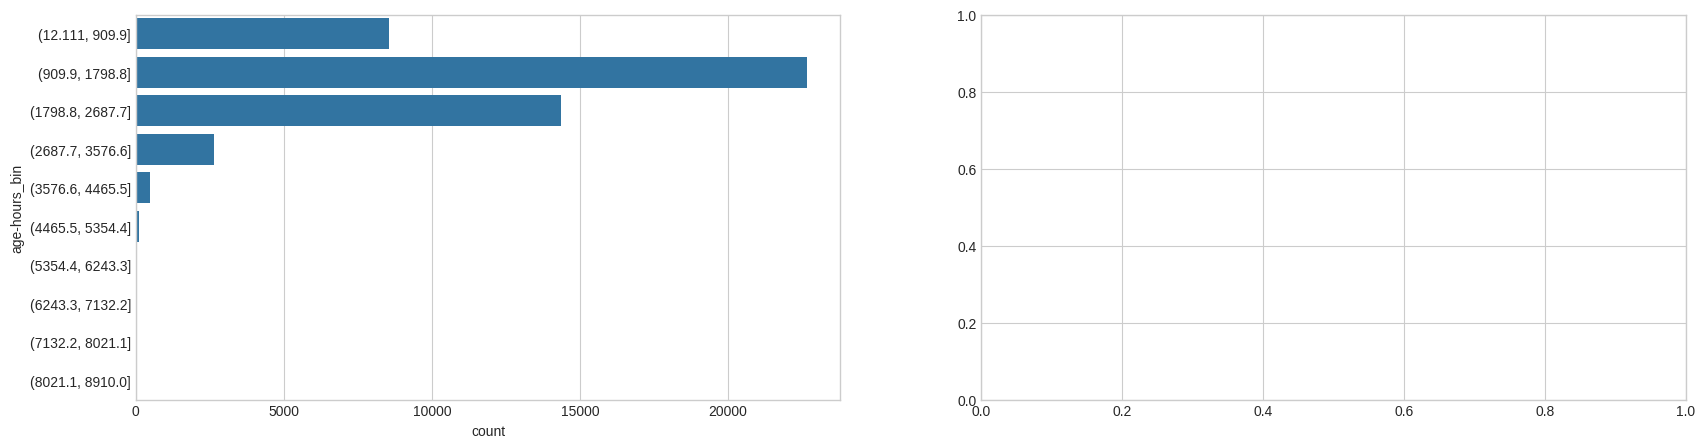

In [32]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
sns.countplot(y="age-hours_bin", data=my_df);
plt.subplot(1, 2, 2)
sns.distplot(my_df[my_df['income'] == '>50K']['age-hours'], kde_kws={"label": ">$50K"})
sns.distplot(my_df[my_df['income'] == '<=50K']['age-hours'], kde_kws={"label": "<$50K"})

## EDA

### Pair Plot

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


KeyError: 'income'

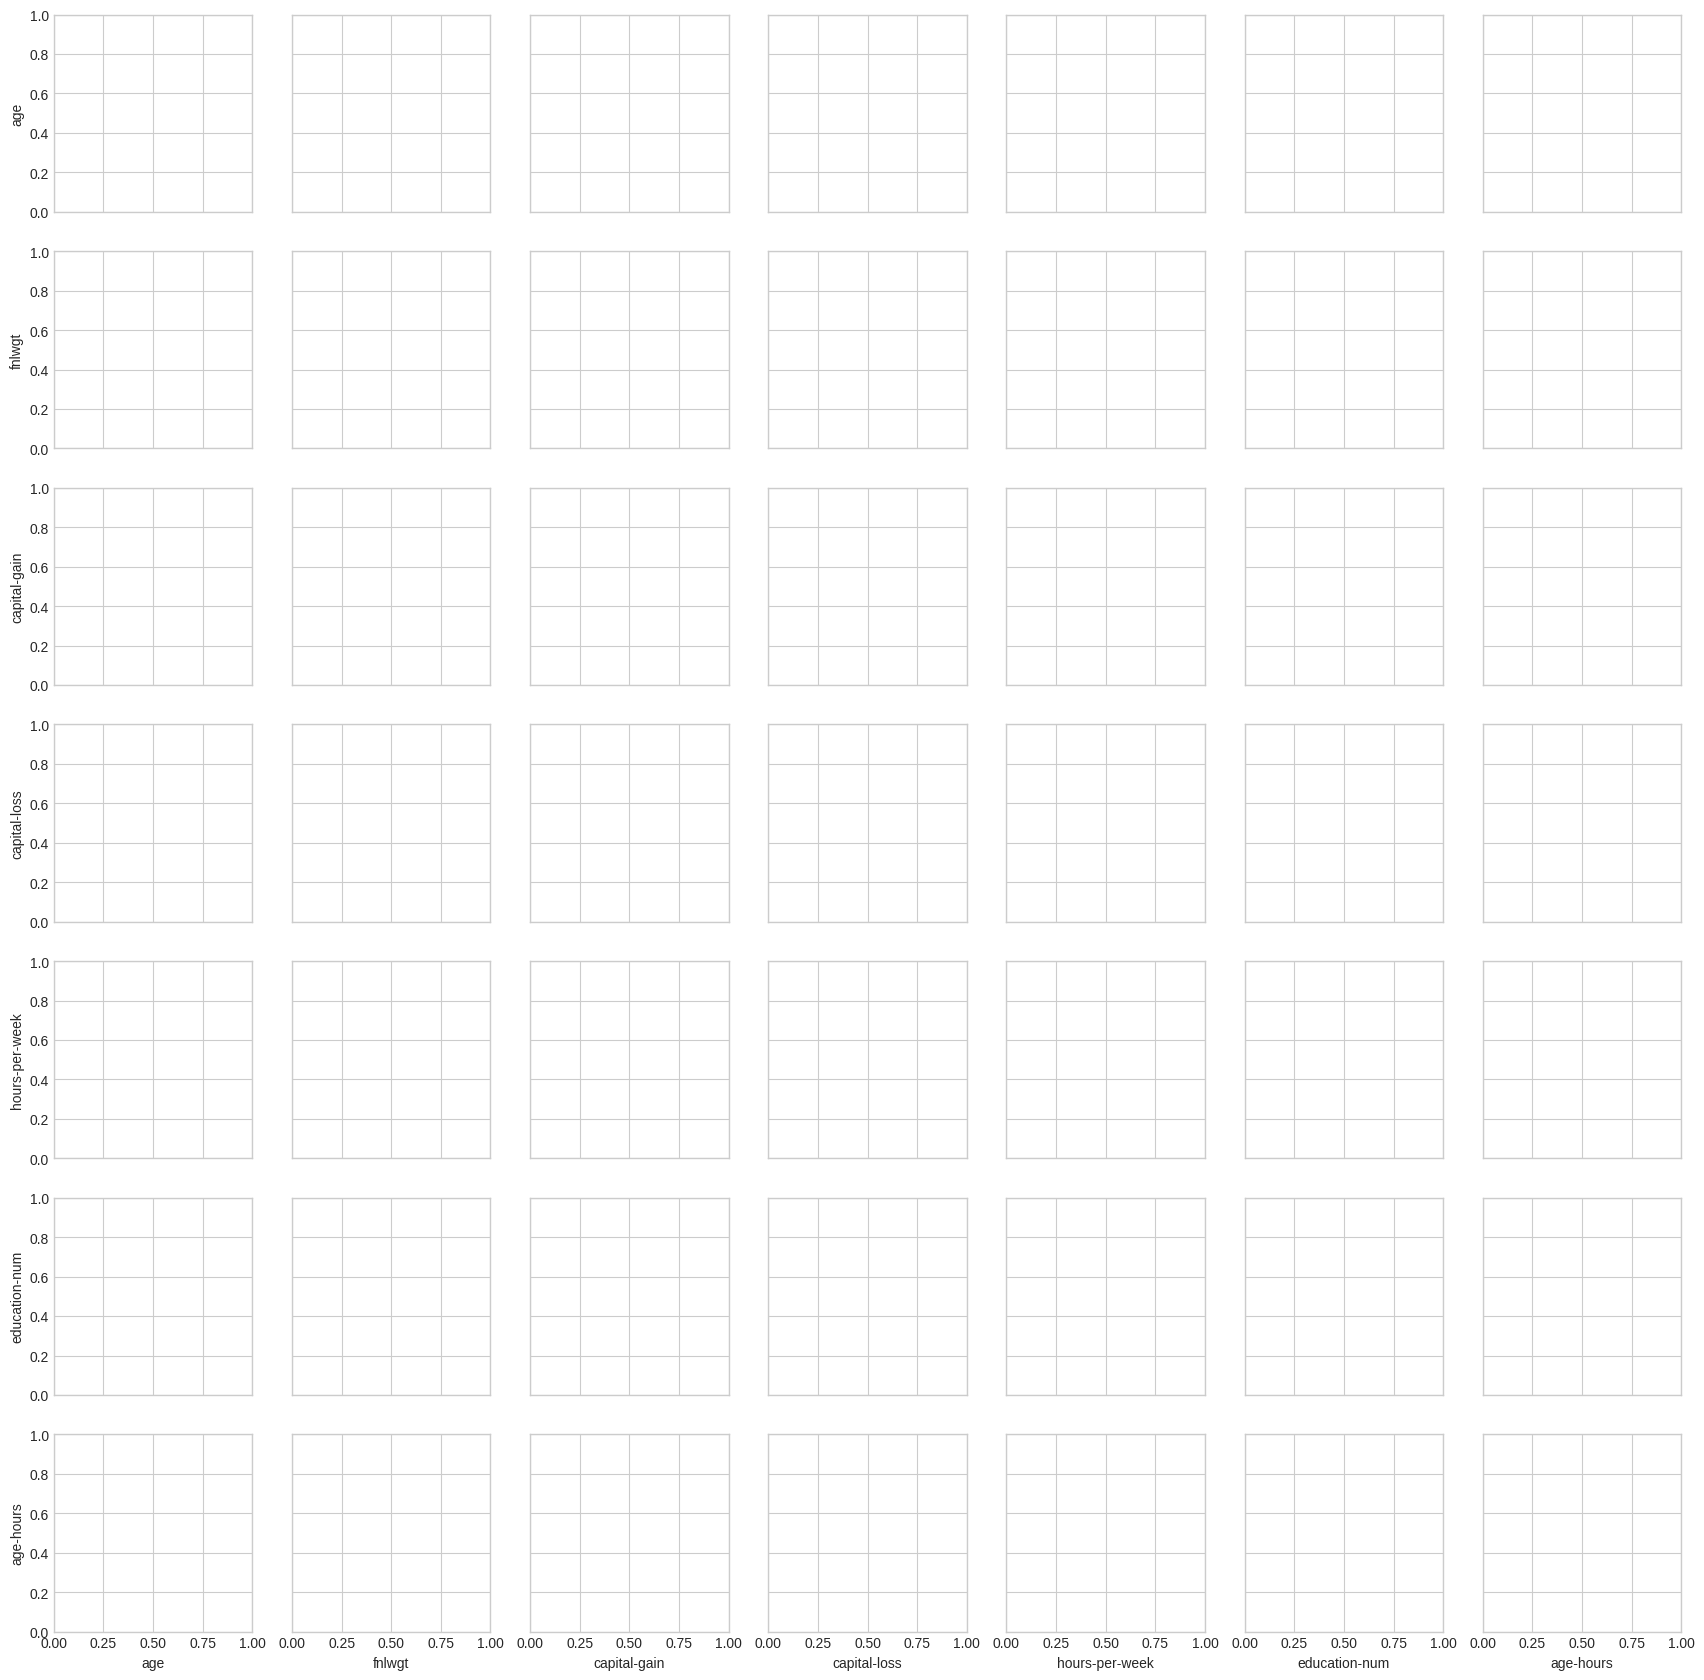

In [33]:
#pair plots of entire dataset
pp = sns.pairplot(my_df, hue = 'income', palette = 'deep',
                  size=3, diag_kind = 'kde', diag_kws=dict(shade=True), plot_kws=dict(s=20) )
pp.set(xticklabels=[])

### Correlation Heatmap

In [ ]:
#correlation heatmap of dataset
def correlation_heatmap(df):
    # Select only numeric columns for correlation calculation
    numeric_df = df.select_dtypes(include=['number'])

    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)

    _ = sns.heatmap(
        numeric_df.corr(), # Use the DataFrame with only numeric columns
        cmap = "YlGn",
        square=True,
        cbar_kws={'shrink':.9 },
        ax=ax,
        annot=True,
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )

    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(my_df)

### Bivariate Analysis

### Occupation vs. Income Level

The general trend is in sync with common sense: more senior workers have higher salaries. Armed-forces don't have a high job salaries.

Interestingly, private house sevice has the widest range of age variation, however, the payment is no higher than 50K, indicating that senority doesn't give rise to a higher payment comparing to other jobs.

### Race vs. Income Level

![censusrace](https://user-images.githubusercontent.com/31974451/36568899-8e25bc6c-17e0-11e8-9e85-53d0f5cc1d7f.png)


## Building Machine Learning Models

In [36]:
from sklearn.cluster import KMeans
from matplotlib import cm
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score

from sklearn.decomposition import PCA
from pandas.plotting import scatter_matrix
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import GridSearchCV


#importing all the required ML packages
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn import svm #support vector Machine
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix
#train,test=train_test_split(train_df,test_size=0.2,random_state=0,stratify=abalone_data['Sex'])

### Feature Encoding

In [37]:
# Feature Selection and Encoding
from sklearn.svm import SVR
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split #training and testing data split


In [40]:
# Load your data into a DataFrame
my_df = pd.read_csv('./adult.csv')  # Replace 'your_file.csv'

# Now you can apply the transformation
my_df = my_df.apply(LabelEncoder().fit_transform)
my_df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,8,4,19329,1,6,4,7,3,2,1,0,0,39,39,0
1,21,4,4212,11,8,2,5,0,4,1,0,0,49,39,0
2,11,2,25340,7,11,2,11,0,4,1,0,0,39,39,1
3,27,4,11201,15,9,2,7,0,2,1,98,0,39,39,1
4,1,0,5411,15,9,4,0,3,4,0,0,0,29,39,0


In [41]:
my_df = my_df.apply(LabelEncoder().fit_transform)
my_df.head()
my_df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'educational-num',
       'marital-status', 'occupation', 'relationship', 'race', 'gender',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

### Train-test split

In [42]:
drop_elements = ['education', 'native-country', 'age']
y = my_df['income']
X = my_df.drop(drop_elements, axis=1)
X.head()

,workclass,fnlwgt,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,income
0,4,19329,6,4,7,3,2,1,0,0,39,0
1,4,4212,8,2,5,0,4,1,0,0,49,0
2,2,25340,11,2,11,0,4,1,0,0,39,1
3,4,11201,9,2,7,0,2,1,98,0,39,1
4,0,5411,9,4,0,3,4,0,0,0,29,0


In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

### Classification Models

#### Perceptron Method

In [45]:
## Perceptron Method
from sklearn.linear_model import Perceptron
ppn = Perceptron(eta0=1, random_state=1)
ppn.fit(X_train, y_train)

Perceptron(eta0=1, random_state=1)

In [46]:
y_pred = ppn.predict(X_test)
accuracy_score(y_pred,y_test)

0.7706008803357559

In [47]:
## cross_val_score for ppn method
from sklearn.model_selection import cross_val_score
score_ppn=cross_val_score(ppn, X,y, cv=5)
score_ppn.mean()

0.6690304552777682

#### Gaussian Naive Bayes

In [48]:
# Gaussian Naive Bayes
gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
# y_pred = gaussian.predict(X_test)
score_gaussian = gaussian.score(X_test,y_test)
print('The accuracy of Gaussian Naive Bayes is', score_gaussian)

The accuracy of Gaussian Naive Bayes is 0.9722591872248951


#### Linear Support Vector Machine

In [49]:
# Support Vector Classifier (SVM/SVC)
from sklearn.svm import SVC
svc = SVC(gamma=0.22)
svc.fit(X_train, y_train)
#y_pred = logreg.predict(X_test)
score_svc = svc.score(X_test,y_test)
print('The accuracy of SVC is', score_svc)

The accuracy of SVC is 0.7659944723103695


#### Logistic Regression

In [ ]:
# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
#y_pred = logreg.predict(X_test)
score_logreg = logreg.score(X_test,y_test)
print('The accuracy of the Logistic Regression is', score_logreg)

#### Random Forest

In [ ]:
# Random Forest Classifier
randomforest = RandomForestClassifier()
randomforest.fit(X_train, y_train)
#y_pred = randomforest.predict(X_test)
score_randomforest = randomforest.score(X_test,y_test)
print('The accuracy of the Random Forest Model is', score_randomforest)

#### K-Nearest Neighbors

In [ ]:
# K-Nearest Neighbors
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
#y_pred = knn.predict(X_test)
score_knn = knn.score(X_test,y_test)
print('The accuracy of the KNN Model is',score_knn)

### Cross Validation

In [ ]:
# ### cross validation
# from sklearn.model_selection import KFold #for K-fold cross validation
# from sklearn.model_selection import cross_val_score #score evaluation
# from sklearn.model_selection import cross_val_predict #prediction
# kfold = KFold(n_splits=10, random_state=22) # k=10, split the data into 10 equal parts
# xyz=[]
# accuracy=[]
# std=[]
# classifiers=['Naive Bayes','Linear Svm','Radial Svm','Logistic Regression','Decision Tree','KNN','Random Forest']
# models=[GaussianNB(), svm.SVC(kernel='linear'),svm.SVC(kernel='rbf'),LogisticRegression(),DecisionTreeClassifier(),
#         KNeighborsClassifier(n_neighbors=9),RandomForestClassifier(n_estimators=100)]
# for i in models:
#     model = i
#     cv_result = cross_val_score(model,X,y, cv = kfold,scoring = "accuracy")
#     cv_result=cv_result
#     xyz.append(cv_result.mean())
#     std.append(cv_result.std())
#     accuracy.append(cv_result)
# models_dataframe=pd.DataFrame({'CV Mean':xyz,'Std':std},index=classifiers)
# models_dataframe

In [ ]:
### cross validation
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
# Set shuffle=True to enable shuffling before splitting
kfold = KFold(n_splits=10, random_state=22, shuffle=True) # k=10, split the data into 10 equal parts
xyz=[]
accuracy=[]
std=[]
classifiers=['Naive Bayes','Linear Svm','Radial Svm','Logistic Regression','Decision Tree','KNN','Random Forest']
models=[GaussianNB(), svm.SVC(kernel='linear'),svm.SVC(kernel='rbf'),LogisticRegression(),DecisionTreeClassifier(),
        KNeighborsClassifier(n_neighbors=9),RandomForestClassifier(n_estimators=100)]
for i in models:
    model = i
    cv_result = cross_val_score(model,X,y, cv = kfold,scoring = "accuracy")
    cv_result=cv_result
    xyz.append(cv_result.mean())
    std.append(cv_result.std())
    accuracy.append(cv_result)
models_dataframe=pd.DataFrame({'CV Mean':xyz,'Std':std},index=classifiers)
models_dataframe